# Expérience des utilisateurs :

1 couleur = 1 utilisateur

In [1]:
from IPython.display import Image

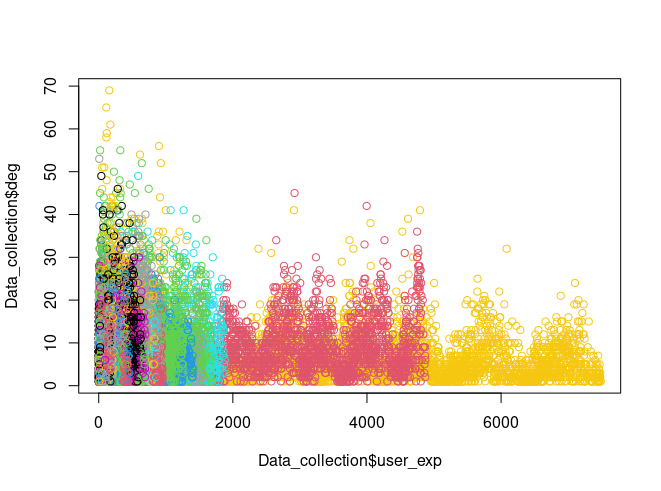

In [2]:
Image(filename="../../../../article3_image/obs_vs_exp.png")

95% des utilisateurs ont moins de 80 observations

Les observations avec un niveau d'expérience supérieur à 80 représente 68% des données.

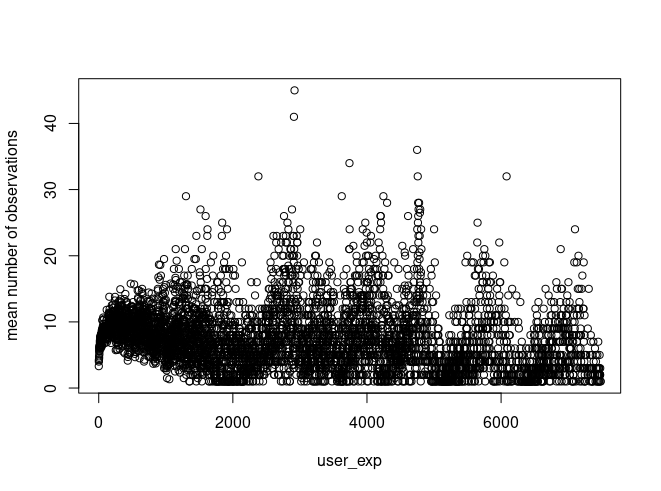

In [3]:
Image(filename="../../../../article3_image/mean_obs_vs_exp_full.png")

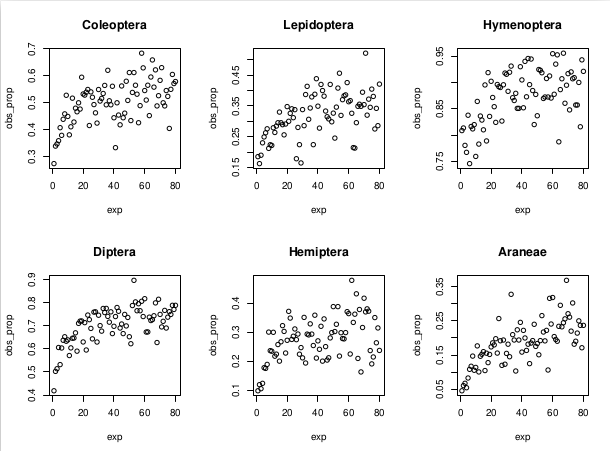

In [4]:
Image(filename="../../../../article3_image/order_exp.png")

# Simulation

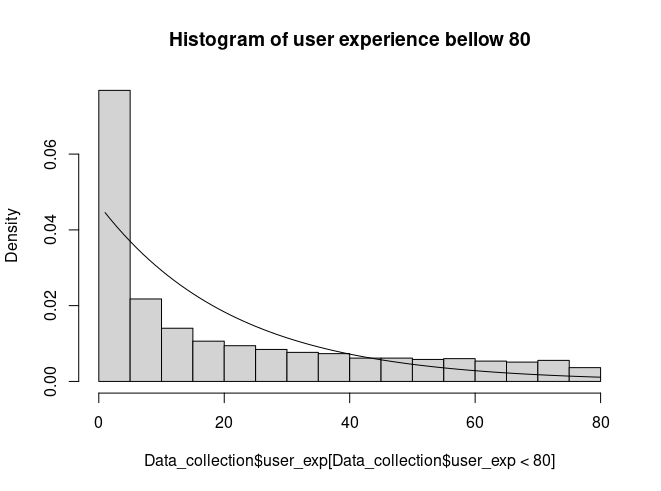

In [5]:
Image(filename="../../../../article3_image/exp_hist.png")

Schéma de simulation proposée :
<ul>
<li>On simule un "vrai réseau bipartite plante-pollinisateur" avec un LBM </li>
<li>On simule l'expérience des utilisateurs $e_i $ selon une loi exponnentielle et on pose $S_i = round(e_i)+1$</li>
<li>Chaque utilisateurs va observer $n_{obs} = round(2\times log(S_i))$ interraction(s) d'une unique espèce de fleur tirée uniformément au hasard  </li>
<li>On obtient alors un réseau observation-insecte qu'on va considérer comme le "vrai réseau observation-insecte" </li>
</ul>

LBM de 83 lignes et 306 colonnes avec paramètre 
0.8 , 0.1
0.1 , 0.7

In [6]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
import scipy.sparse as sp
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from preprocessing import *
from fair_model import *
from HSIC import *
import pandas
import scipy

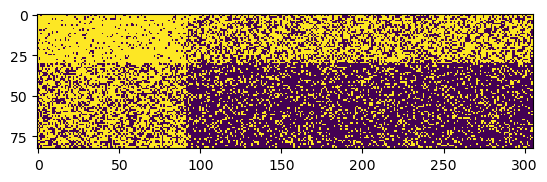

In [40]:
#bipartite_net = np.random.randint(2,size=(83,306))

def simulate_lbm(n1,n2,alpha,beta,P):
    W1 = np.random.choice(len(alpha),replace=True,p=alpha, size=n1)
    W2 = np.random.choice(len(beta) ,replace=True,p=beta , size=n2)
    proba = (P[W1].T[W2]).T
    M = np.random.binomial(1,proba)
    return W1,W2,M

alpha = (0.3,0.7)
beta = (0.3,0.7)
P = np.array([[0.9,0.6],[0.6,0.2]])
n01=83
n02=306
W1,W2,bipartite_net = simulate_lbm(n01, n02, alpha, beta, P) 
plt.imshow(bipartite_net[np.argsort(W1),:][:,np.argsort(W2)],interpolation="none")

In [41]:
np.array([0.2,1])[W1]

array([1. , 1. , 1. , 0.2, 1. , 0.2, 1. , 0.2, 0.2, 1. , 0.2, 1. , 1. ,
       0.2, 0.2, 0.2, 1. , 0.2, 0.2, 1. , 1. , 1. , 1. , 1. , 0.2, 0.2,
       1. , 1. , 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 1. , 1. , 1. ,
       1. , 0.2, 1. , 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 0.2,
       1. , 1. , 0.2, 0.2, 0.2, 0.2, 1. , 0.2, 1. , 1. , 0.2, 1. , 0.2,
       1. , 1. , 1. , 0.2, 1. , 0.2, 1. , 0.2, 1. , 1. , 0.2, 1. , 1. ,
       1. , 1. , 1. , 0.2, 0.2])

In [42]:
W3 = np.ones(len(W1))
W4 = np.random.binomial(1,np.array([0.5,1])[W2])

In [94]:
W3,W4 = np.random.binomial(1,0.8,n01),np.random.binomial(1,0.8,n02)


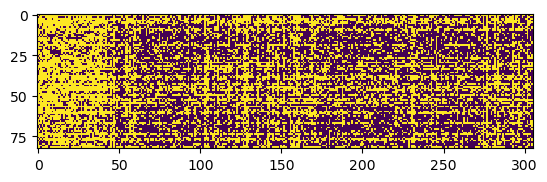

In [43]:
plt.imshow(bipartite_net[np.argsort(W3),:][:,np.argsort(W4)],interpolation="none")


In [11]:
W4

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [92]:
n1 = 6000
proba_obs1 = np.array([1/10,9/10])[W4]

user_exp = np.random.exponential(21,size=n1)
user_exp = np.round(user_exp)+1
nb_obs = np.round(2*np.log(user_exp))
species_index0 = np.random.randint(83,size=n1)
species = np.zeros((species_index0.size, species_index0.max() + 1))
species[np.arange(species_index0.size), species_index0] = 1

net0 = np.zeros((n1,306))
net_index=np.where(bipartite_net>0)
for k in range(n1):
    possible = net_index[1][net_index[0]==species_index0[k]]
    proba_possible = proba_obs1[possible]
    proba_possible = proba_possible/sum(proba_possible)
    observed = np.random.choice(possible,int(nb_obs[k]),p=proba_possible)
    net0[k,observed] = 1



In [93]:
possible

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,  15,
        16,  18,  20,  21,  22,  23,  24,  28,  29,  30,  31,  32,  33,
        34,  37,  38,  40,  42,  43,  44,  45,  47,  49,  50,  51,  52,
        53,  54,  55,  57,  59,  60,  62,  65,  66,  67,  68,  69,  70,
        71,  72,  75,  76,  77,  80,  82,  83,  84,  86,  87,  89,  92,
        93,  94,  96,  97,  98,  99, 100, 101, 103, 105, 107, 108, 110,
       111, 113, 114, 115, 116, 117, 118, 120, 123, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 137, 139, 140, 141, 142, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 154, 156, 157, 158, 159, 160, 162,
       163, 167, 168, 169, 171, 173, 174, 175, 176, 178, 179, 180, 182,
       184, 185, 186, 188, 189, 190, 192, 193, 194, 195, 196, 199, 200,
       202, 204, 205, 209, 210, 214, 215, 216, 217, 218, 219, 220, 222,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 245, 246, 247, 249, 25

In [94]:
(bipartite_net>0).sum()

11680

In [95]:
SP = (species/species.sum(0)).T

In [96]:
((species.T@net0)>0).sum()

9276

In [97]:
bipartite_obs = (SP@net0)

In [98]:
1*(bipartite_obs>0).sum()

9276

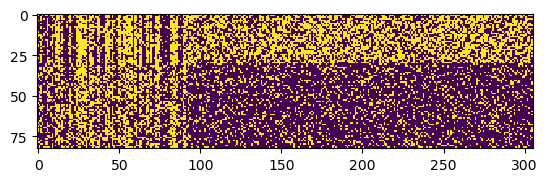

In [99]:
plt.imshow(1*(bipartite_obs>0)[np.argsort(W1),:][:,np.argsort(W2)],interpolation="none")


In [100]:
print((bipartite_obs>0)[W1==0,:][:,W2==0].mean())
print((bipartite_obs>0)[W1==1,:][:,W2==0].mean())
print((bipartite_obs>0)[W1==0,:][:,W2==1].mean())
print((bipartite_obs>0)[W1==1,:][:,W2==1].mean())

0.4957924263674614
0.4383361204013378
0.535875791377751
0.1985981308411215


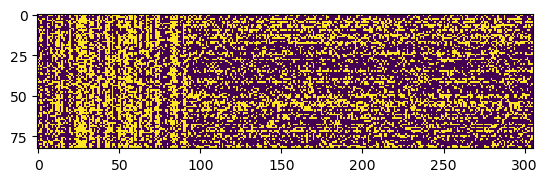

In [101]:
plt.imshow((bipartite_obs>0)[:,np.argsort(W2)],interpolation="none")


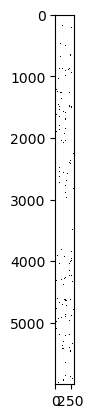

In [102]:
plt.imshow(net0,cmap="Greys",interpolation="none")

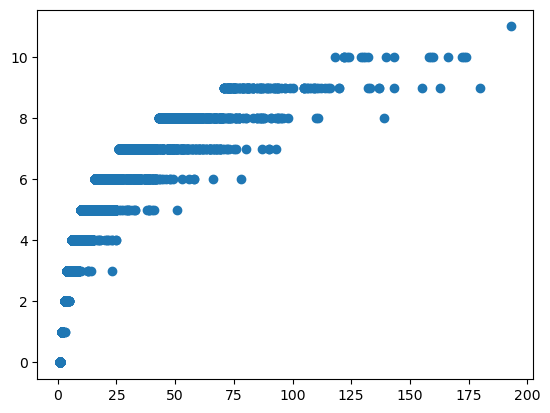

In [103]:
plt.scatter(user_exp,net0.sum(1))

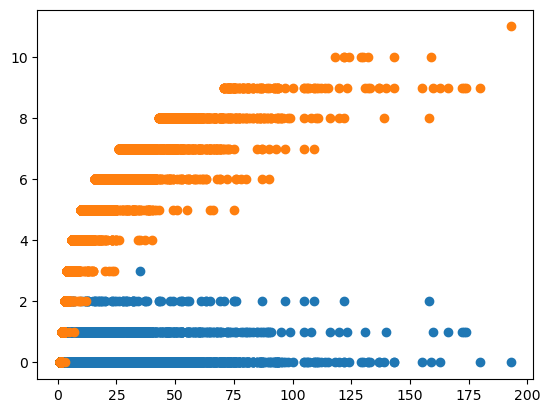

In [104]:
plt.scatter(user_exp,net0[:,W4==0].sum(1))
plt.scatter(user_exp,net0[:,W4==1].sum(1))

In [57]:
args.input_dim1 = n01
args.input_dim2 = n02

## Deuxième modèle de simu

In [85]:
z2 = np.random.binomial(1,0.5,10)
z2= (z2-0.5)*2*2.5

In [86]:
np.concatenate([z2.reshape(-1,1),z2.reshape(-1,1)],axis=1)

array([[ 2.5,  2.5],
       [-2.5, -2.5],
       [ 2.5,  2.5],
       [ 2.5,  2.5],
       [-2.5, -2.5],
       [-2.5, -2.5],
       [ 2.5,  2.5],
       [-2.5, -2.5],
       [ 2.5,  2.5],
       [ 2.5,  2.5]])

In [87]:
import networkx as nx

n01=83
n02=306
np.random.seed(5)
#z = np.random.normal(size=(n01,1))
z1x = np.random.binomial(1,0.5,n01).reshape(-1,1)
z1x=  np.array([-2,2])[z1x]
z1x = np.random.normal(loc=z1x)

z0 = np.zeros((n01,1))
#s = np.random.normal(size=(n1,1))
#s = np.random.binomial(1, 0.5,size = (n1,1))*2-1

z1 = np.concatenate([z1x,z0],axis=1)
#z1 = np.concatenate([z,s],axis=1)

z2x = np.random.binomial(1,0.5,n02).reshape(-1,1)
z2x=  np.array([-2.5,2.5])[z2x]
z2x = np.random.normal(loc=z2x)
z2y = np.random.normal(loc=0,size = (n02,1))
z2=np.concatenate([z2x,z2y],axis=1)

torch.manual_seed(0)
netbis=torch.bernoulli(distance_decode(torch.Tensor(z1),torch.Tensor(z2))).numpy()
non_zero1 = netbis.sum(1)>0
non_zero2 = netbis.sum(0)>0
z1 = z1[non_zero1]
z2 = z2[non_zero2]
bipartite_net = netbis[non_zero1,:][:,non_zero2]
n01 = sum(non_zero1)
n02 = sum(non_zero2)

adj = sp.csr_matrix(bipartite_net) 

In [88]:
score0=distance_decode(torch.Tensor(z1),torch.Tensor(z2))

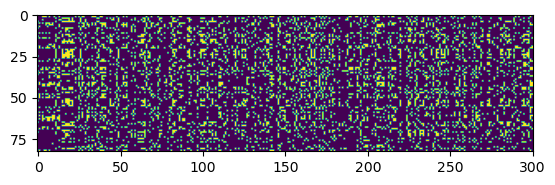

In [25]:
plt.imshow(bipartite_net)

In [26]:
G=nx.algorithms.bipartite.from_biadjacency_matrix(adj)
position = {k: np.vstack([z1,z2])[k] for k in G.nodes.keys()}

Text(0.5, 1.0, 'Simulated latent space')

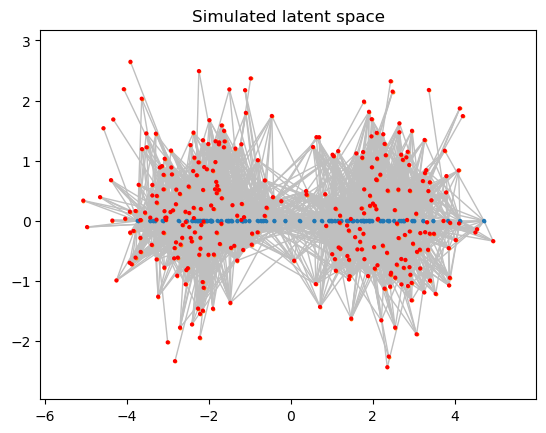

In [27]:
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 position,
                 node_size=4,
                 with_labels=False,
                 node_color = sum(non_zero1)*["#1f77b4"]+sum(non_zero2)*["red"],
                 edge_color = (0.75,0.75,0.75),
                 ax=ax)
plt.title("Simulated latent space")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#blue_patch = mpatches.Patch( label=r'$Z_1$')
#red_patch = mpatches.Patch(color='red', label=r'$Z_2$')
#fig.legend(handles=[blue_patch,red_patch])


plt.scatter(z1[:,0],z1[:,1],s=3)
plt.scatter(z2[:,0],z2[:,1],s=3)
plt.title("Simulated latent space")

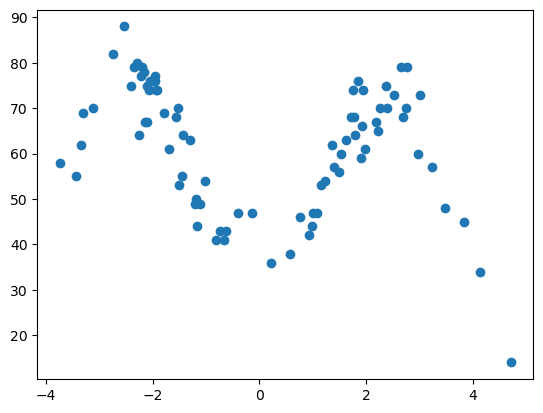

In [28]:
plt.scatter(z1[:,0],bipartite_net.sum(1).reshape(-1,1))

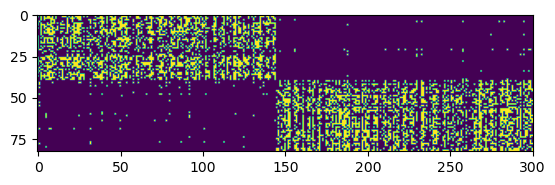

In [29]:
plt.imshow(bipartite_net[:,np.argsort(z2[:,0]<0)][np.argsort(z1[:,0]<0),:])

In [30]:
n1 = 1500

user_exp = np.random.normal(size=n1)*0.75
#user_exp = np.random.exponential(1/10,size=n1)

#user_exp = np.round(user_exp)+1
#nb_obs = np.round(2*np.log(user_exp))
species_index0 = np.random.randint(n01,size=n1)
species = np.zeros((species_index0.size, species_index0.max() + 1))
species[np.arange(species_index0.size), species_index0] = 1

In [31]:
z1_bis = z1[species_index0,:]
z1_bis[:,1] = user_exp

Text(0.5, 1.0, 'Simulated latent space')

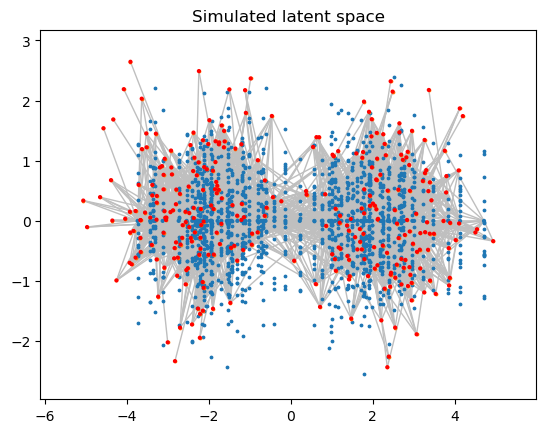

In [32]:
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 position,
                 node_size=4,
                 with_labels=False,
                 node_color = sum(non_zero1)*["#1f77b4"]+sum(non_zero2)*["red"],
                 edge_color = (0.75,0.75,0.75),
                 ax=ax)
plt.title("Simulated latent space")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#blue_patch = mpatches.Patch( label=r'$Z_1$')
#red_patch = mpatches.Patch(color='red', label=r'$Z_2$')
#fig.legend(handles=[blue_patch,red_patch])


plt.scatter(z1_bis[:,0],z1_bis[:,1],s=3)
plt.scatter(z2[:,0],z2[:,1],s=3)
plt.title("Simulated latent space")

In [33]:
net0 = np.zeros((n1,n02))
net_index=np.where(bipartite_net>0)
for k in range(n1):
    possible = net_index[1][net_index[0]==species_index0[k]]
    vu_possible = torch.bernoulli(distance_decode(torch.Tensor(z1_bis[k,:].reshape(-1,2)),torch.Tensor(z2)))[:,possible]
    net0[k,possible] = vu_possible

In [34]:
SP = (species/species.sum(0)).T

In [35]:
bipartite_obs = (SP@net0)

In [36]:
(bipartite_obs>0).sum()

5027

In [37]:
bipartite_net.sum()

5125.0

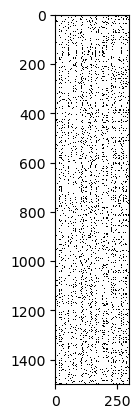

In [38]:
plt.imshow(net0,cmap="Greys",interpolation="none")

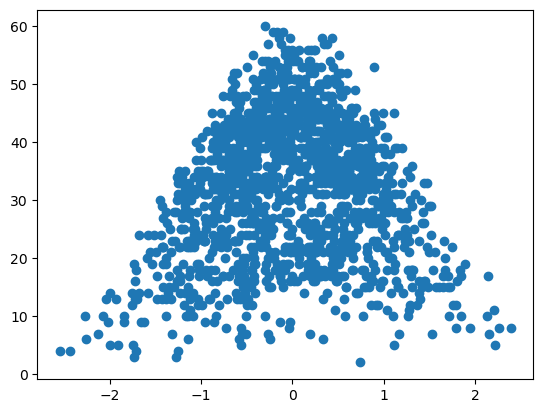

In [39]:
plt.scatter(user_exp,net0.sum(1))

In [40]:
args.input_dim1 = n01
args.input_dim2 = n02

## Troisième modèle de simu

In [8]:
import networkx as nx

n01=83
n02=306
np.random.seed(5)
#z = np.random.normal(size=(n01,1))
z1x_index = np.random.binomial(1,0.5,n01).reshape(-1,1)
z1x=  np.array([-2,2])[z1x_index]
z1x = np.random.normal(loc=z1x)

#z0 = np.zeros((n01,1))
z0 = np.random.normal(size=(n01,1))

#s = np.random.normal(size=(n1,1))
#s = np.random.binomial(1, 0.5,size = (n1,1))*2-1

z1 = np.concatenate([z1x,z0],axis=1)
#z1 = np.concatenate([z,s],axis=1)

z2x_index = np.random.binomial(1,0.5,n02).reshape(-1,1)
z2x=  np.array([-2.5,2.5])[z2x_index]
z2x = np.random.normal(loc=z2x)
z2y=  np.array([0,2])[z2x_index]
z2y = np.random.normal(loc=z2y,size = (n02,1))
z2=np.concatenate([z2x,z2y],axis=1)

score0=distance_decode(torch.Tensor(z1),torch.Tensor(z2))

In [9]:

bipartite_net=torch.bernoulli(score0)
adj = sp.csr_matrix(bipartite_net) 

In [10]:
adj.shape

(83, 306)

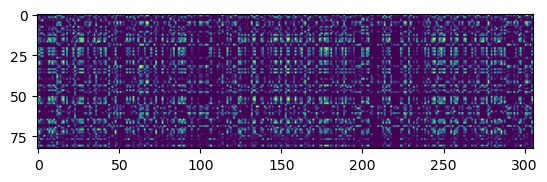

In [11]:
plt.imshow(score0)

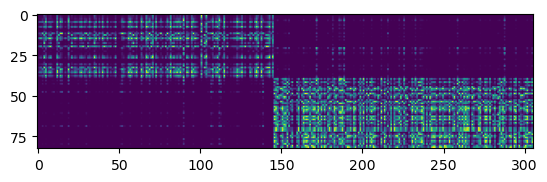

In [12]:
plt.imshow(score0[:,np.argsort(z2[:,0]<0)][np.argsort(z1[:,0]<0),:])

In [13]:
G=nx.algorithms.bipartite.from_biadjacency_matrix(adj)
position = {k: np.vstack([z1,z2])[k] for k in G.nodes.keys()}

Text(0.5, 1.0, 'Simulated latent space')

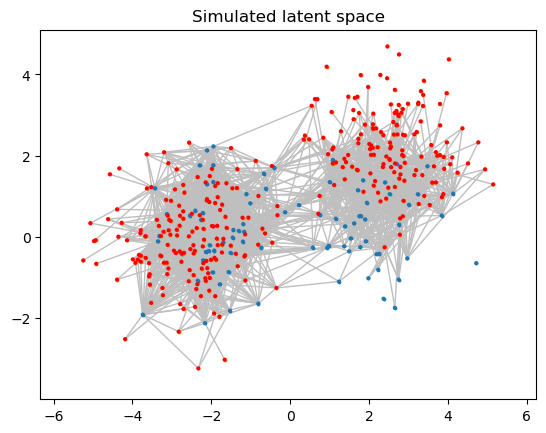

In [14]:
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 position,
                 node_size=4,
                 with_labels=False,
                 node_color = n01*["#1f77b4"]+n02*["red"],
                 edge_color = (0.75,0.75,0.75),
                 ax=ax)
plt.title("Simulated latent space")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#blue_patch = mpatches.Patch( label=r'$Z_1$')
#red_patch = mpatches.Patch(color='red', label=r'$Z_2$')
#fig.legend(handles=[blue_patch,red_patch])


plt.scatter(z1[:,0],z1[:,1],s=3)
plt.scatter(z2[:,0],z2[:,1],s=3)
plt.title("Simulated latent space")

In [15]:
z1z = np.random.normal(0,size=(n01,1))
z2z = np.random.normal(0,size=(n02,1))

In [16]:
z1 = np.concatenate([z1x,z0,z1z],axis=1)
z2 =np.concatenate([z2x,z2y,z2z],axis=1)
score_obs=distance_decode(torch.Tensor(z1),torch.Tensor(z2))

net0=torch.bernoulli(score_obs)
adj = sp.csr_matrix(net0) 


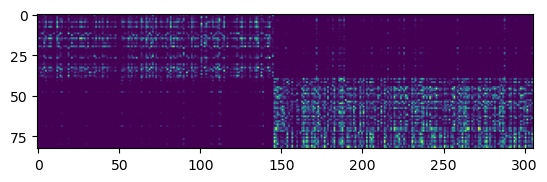

In [17]:
plt.imshow(score_obs[:,np.argsort(z2[:,0]<0)][np.argsort(z1[:,0]<0),:])

Text(0.5, 1.0, 'Simulated latent space')

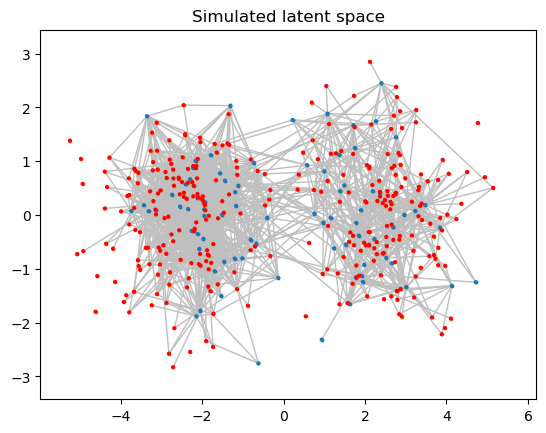

In [18]:
G=nx.algorithms.bipartite.from_biadjacency_matrix(adj)
position = {k: np.vstack([z1[:,[0,2]],z2[:,[0,2]]])[k] for k in G.nodes.keys()}
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 position,
                 node_size=4,
                 with_labels=False,
                 node_color = n01*["#1f77b4"]+n02*["red"],
                 edge_color = (0.75,0.75,0.75),
                 ax=ax)
plt.title("Simulated latent space")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#blue_patch = mpatches.Patch( label=r'$Z_1$')
#red_patch = mpatches.Patch(color='red', label=r'$Z_2$')
#fig.legend(handles=[blue_patch,red_patch])


plt.scatter(z1[:,0],z1[:,2],s=3)
plt.scatter(z2[:,0],z2[:,2],s=3)
plt.title("Simulated latent space")

Text(0.5, 1.0, 'Simulated latent space')

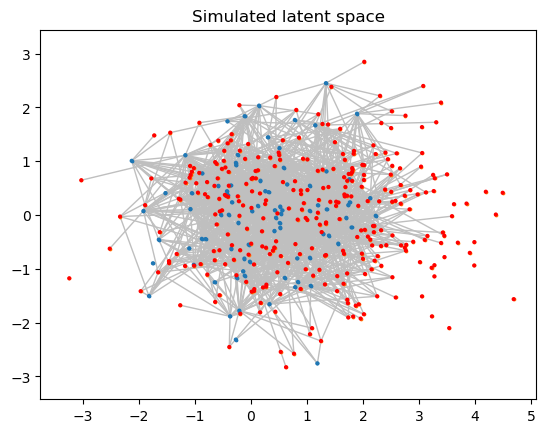

In [19]:
G=nx.algorithms.bipartite.from_biadjacency_matrix(adj)
position = {k: np.vstack([z1[:,[1,2]],z2[:,[1,2]]])[k] for k in G.nodes.keys()}
fig, ax = plt.subplots()
nx.draw_networkx(G,
                 position,
                 node_size=4,
                 with_labels=False,
                 node_color = n01*["#1f77b4"]+n02*["red"],
                 edge_color = (0.75,0.75,0.75),
                 ax=ax)
plt.title("Simulated latent space")
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
#blue_patch = mpatches.Patch( label=r'$Z_1$')
#red_patch = mpatches.Patch(color='red', label=r'$Z_2$')
#fig.legend(handles=[blue_patch,red_patch])


plt.scatter(z1[:,1],z1[:,2],s=3)
plt.scatter(z2[:,1],z2[:,2],s=3)
plt.title("Simulated latent space")

## Fit

In [105]:
adj0 = net0
species01 = pandas.DataFrame(species.copy())
features1 =species01.copy()
features02 = np.eye(adj0.shape[1])
features1 = sp.csr_matrix(features1) 
species1 = sp.csr_matrix(species01) 
features2 = sp.csr_matrix(features02) 
adj = sp.csr_matrix(adj0) 
features1 = sparse_to_tuple(features1.tocoo())
species1 = sparse_to_tuple(species1.tocoo())
features2 = sparse_to_tuple(features2.tocoo())
adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj0)
adj_norm = preprocess_graph(adj_train)
n=adj.shape[0]
# Create Model
pos_weight = float(adj.shape[0] * adj.shape[1] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[1] / float((adj.shape[0] * adj.shape[1] - adj.sum()) * 2)
adj_label = adj_train 
adj_label = sparse_to_tuple(adj_label)
adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))


features1 = torch.sparse.FloatTensor(torch.LongTensor(features1[0].T), 
                            torch.FloatTensor(features1[1]), 
                            torch.Size(features1[2]))
features2 = torch.sparse.FloatTensor(torch.LongTensor(features2[0].T), 
                            torch.FloatTensor(features2[1]), 
                            torch.Size(features2[2]))

species1 = torch.sparse.FloatTensor(torch.LongTensor(species1[0].T), 
                            torch.FloatTensor(species1[1]), 
                            torch.Size(species1[2]))

weight_mask = adj_label.to_dense().view(-1) == 1
weight_tensor = torch.ones(weight_mask.size(0)) 
weight_tensor[weight_mask] = pos_weight

##########################################

species_index =  np.array((np.where(species01))).T[:,1]

#bipartite,val_edges2,val_edges_false2,test_edges2,test_edges_false2=mask_test_edges2(adj_label,species01.to_numpy(), val_edges, val_edges_false, test_edges, test_edges_false)
bipartite,val_edges2,val_edges_false2,test_edges2,test_edges_false2=mask_test_edges3(adj_label,species01.to_numpy(),bipartite_net, val_edges, val_edges_false, test_edges, test_edges_false)

pos_weight2 = (bipartite.shape[0]*bipartite.shape[1]-bipartite.sum())/(bipartite.sum())
weight_tensor2 = torch.ones(bipartite.reshape(-1).shape[0]) 
weight_tensor2[bipartite.reshape(-1)==1] = pos_weight2

norm2 = bipartite.shape[0] * bipartite.shape[1] / float((bipartite.shape[0] *bipartite.shape[1] - bipartite.sum()) * 2)

In [106]:
species_index

array([20, 49, 33, ..., 71, 25, 72])

In [107]:
S0= torch.Tensor(user_exp).reshape(-1,1)
S = S0.clone()
S[:,0] = torch.log10(S0[:,0])
S = (S0-S0.mean(0))/S0.std(0)
#S = S0.clone()
import args


In [108]:
# init model and optimizer

torch.manual_seed(2)
model = VBGAE2(adj_norm,species_index)
init_parameters(model)

optimizer = Adam(model.parameters(), lr=args.learning_rate)

# train model
roclist = []
loss_list= []


torch.manual_seed(1)
pbar = tqdm(range(int(args.num_epoch)),desc = "Training Epochs")
for epoch in pbar:
    t = time.time()

    A_pred,A_pred2,Z1,Z2,Z3 = model(features1,features2)
    optimizer.zero_grad()
    loss  = norm2*F.binary_cross_entropy(A_pred2.view(-1), torch.Tensor(bipartite).view(-1),weight = weight_tensor2)
    loss += norm*F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight = weight_tensor)
    kl_divergence = 0.5/ A_pred.size(0) *( (1 + 2*model.logstd1 - model.mean1**2 - torch.exp(model.logstd1)**2).sum(1).mean()+
                                          (1 + 2*model.logstd2 - model.mean2**2 - torch.exp(model.logstd2)**2).sum(1).mean())
    loss -= kl_divergence
    loss.backward()
    optimizer.step()
    

    val_roc, val_ap = get_scores(val_edges, val_edges_false, A_pred)
    val_roc2, val_ap2 = get_scores(val_edges2, val_edges_false2, A_pred2)
    
    roclist.append(val_roc2)
    loss_list.append(loss.item())

    pbar.set_postfix({"train_loss=": "{:.5f}".format(loss.item()),
                      'val_roc=': val_roc,
                      "val_roc2=": "{:.5f}".format(val_roc2)})


Training Epochs: 100%|██████████| 1000/1000 [01:06<00:00, 15.08it/s, train_loss==1.23294, val_roc==0.639, val_roc2==0.58437]


In [109]:
A_pred,A_pred2,Z1,Z2,Z3 = model(features1,features2)

test_roc, test_ap = get_scores(test_edges, test_edges_false, A_pred)
print("1) End of training!", "test_roc=", "{:.5f}".format(test_roc),
      "test_ap=", "{:.5f}".format(test_ap))

test_roc2, test_ap2 = get_scores(test_edges2, test_edges_false2, A_pred2)
print("2) End of training!", "test_roc=", "{:.5f}".format(test_roc2),
      "test_ap=", "{:.5f}".format(test_ap2))


SP = (species01/species01.sum(0)).T.to_numpy()
A_pred3 = (SP@A_pred.detach().numpy())
test_roc3, test_ap3= get_scores(test_edges2, test_edges_false2,torch.Tensor(A_pred3))
print("3) End of training!", "test_roc=", "{:.5f}".format(test_roc3),
      "test_ap=", "{:.5f}".format(test_ap3))

1) End of training! test_roc= 0.63327 test_ap= 0.61576
2) End of training! test_roc= 0.31824 test_ap= 0.40781
3) End of training! test_roc= 0.28019 test_ap= 0.40111


In [110]:
proba = (P[W1].T[W2]).T
print(scipy.stats.spearmanr(proba[bipartite_obs==0].reshape(-1,1),
                      A_pred3[bipartite_obs==0].reshape(-1,1)))

SignificanceResult(statistic=-0.012006665808566252, pvalue=0.12739574698888095)


In [117]:
print(scipy.stats.spearmanr(score0.reshape(-1,1),A_pred3.reshape(-1,1)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 24983 and the array at index 1 has size 25398

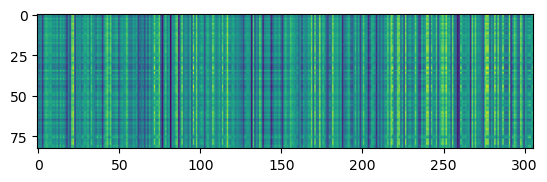

In [64]:
plt.imshow(A_pred3)

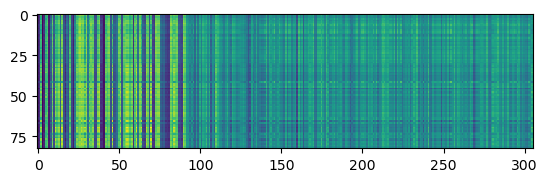

In [65]:
plt.imshow((A_pred3)[np.argsort(W1),:][:,np.argsort(W2)],interpolation="none")


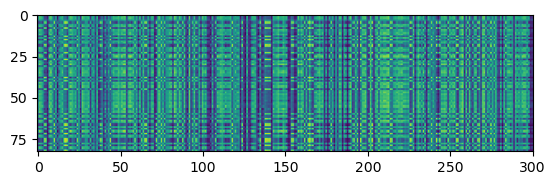

In [120]:
plt.imshow(A_pred3[:,np.argsort(z2[:,0]<0)][np.argsort(z1[:,0]<0),:])

In [121]:
8/7

1.1428571428571428

In [168]:
A_pred3[:,W4==1].mean()-A_pred3[:,W4==0].mean()

NameError: name 'W4' is not defined

In [169]:
A_pred3[W1==0,:][:,W2==0].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [170]:
A_pred3[W1==1,:][:,W2==1].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [171]:
A_pred3[W1==0,:][:,W2==1].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [172]:
A_pred3[W1==1,:][:,W2==0].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [173]:
A_pred3[W1==1,:][:,W2==1].mean()/A_pred3[W1==0,:][:,W2==0].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [174]:
A_pred3[W1==0,:][:,W2==1].mean()/A_pred3[W1==1,:][:,W2==0].mean()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 301 but corresponding boolean dimension is 306

In [209]:
np.round(np.corrcoef(model.mean1.detach().numpy().T,S.T),3)


array([[ 1.   , -0.896, -0.907, -0.946,  0.014],
       [-0.896,  1.   ,  0.991,  0.724,  0.01 ],
       [-0.907,  0.991,  1.   ,  0.735,  0.004],
       [-0.946,  0.724,  0.735,  1.   , -0.023],
       [ 0.014,  0.01 ,  0.004, -0.023,  1.   ]])

9.145299920332244e-14

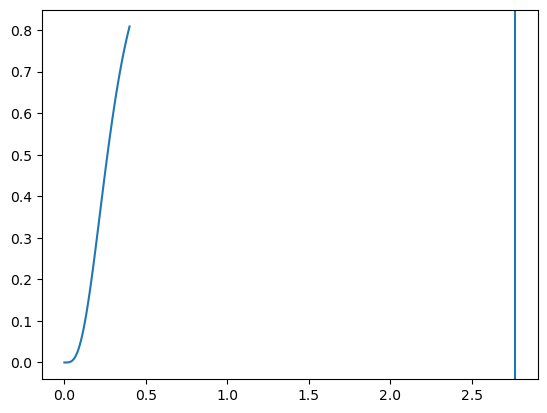

In [210]:
stat1 = HSIC_stat(model.mean1,S)
x = np.linspace(0, 0.4, 100)
y = stats.gamma.cdf(x,stat1[3].item(),scale=stat1[4].item())
plt.plot(x,y)
plt.axvline(x = stat1[0].item()*n)
stats.gamma.sf(stat1[0].item()*n, stat1[3].item(), scale=stat1[4].item())

In [33]:
def plot_latent_space(latent_space1,latent_space2,coloration):
    
    fig,axs = plt.subplots(args.hidden2_dim1-1,args.hidden2_dim1-1,figsize = (15,15))

    for i in range(args.hidden2_dim1,):
        for j in range(i+1,args.hidden2_dim1,):
            A=axs[i,j-1].scatter(latent_space1[:,i],latent_space1[:,j],
                        label="Collection",s=3,
                        c=coloration)
            axs[i,j-1].scatter(latent_space2[:,i],latent_space2[:,j],
                        s=5,label="Observed insects",
                        marker="^",c="r")


    for i in range(1,args.hidden2_dim1-1):
        for j in range(i):
            axs[i,j].axis("off")



    for j in range(args.hidden2_dim1-1):
        axs[0,j].set_title("dim "+str(j+2))

    for i in range(args.hidden2_dim1-1):
        axs[i,i].set_ylabel("dim " +str(i+1))


    handles, labels = axs[0,0].get_legend_handles_labels()
    legend=axs[1,0].legend(handles, labels, loc='lower center', prop={'size': 20})
    for handle in legend.legendHandles:
        handle.set_sizes([60.0])
    cb=fig.colorbar(A,ax= axs[args.hidden2_dim1-2,:args.hidden2_dim1-2],location='top')
    cb.set_label(label=r"$log_{10}$ user exp",size=20)
    cb.ax.xaxis.set_label_position("bottom")
    plt.show()
    

/tmp/ipykernel_1106636/178291780.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


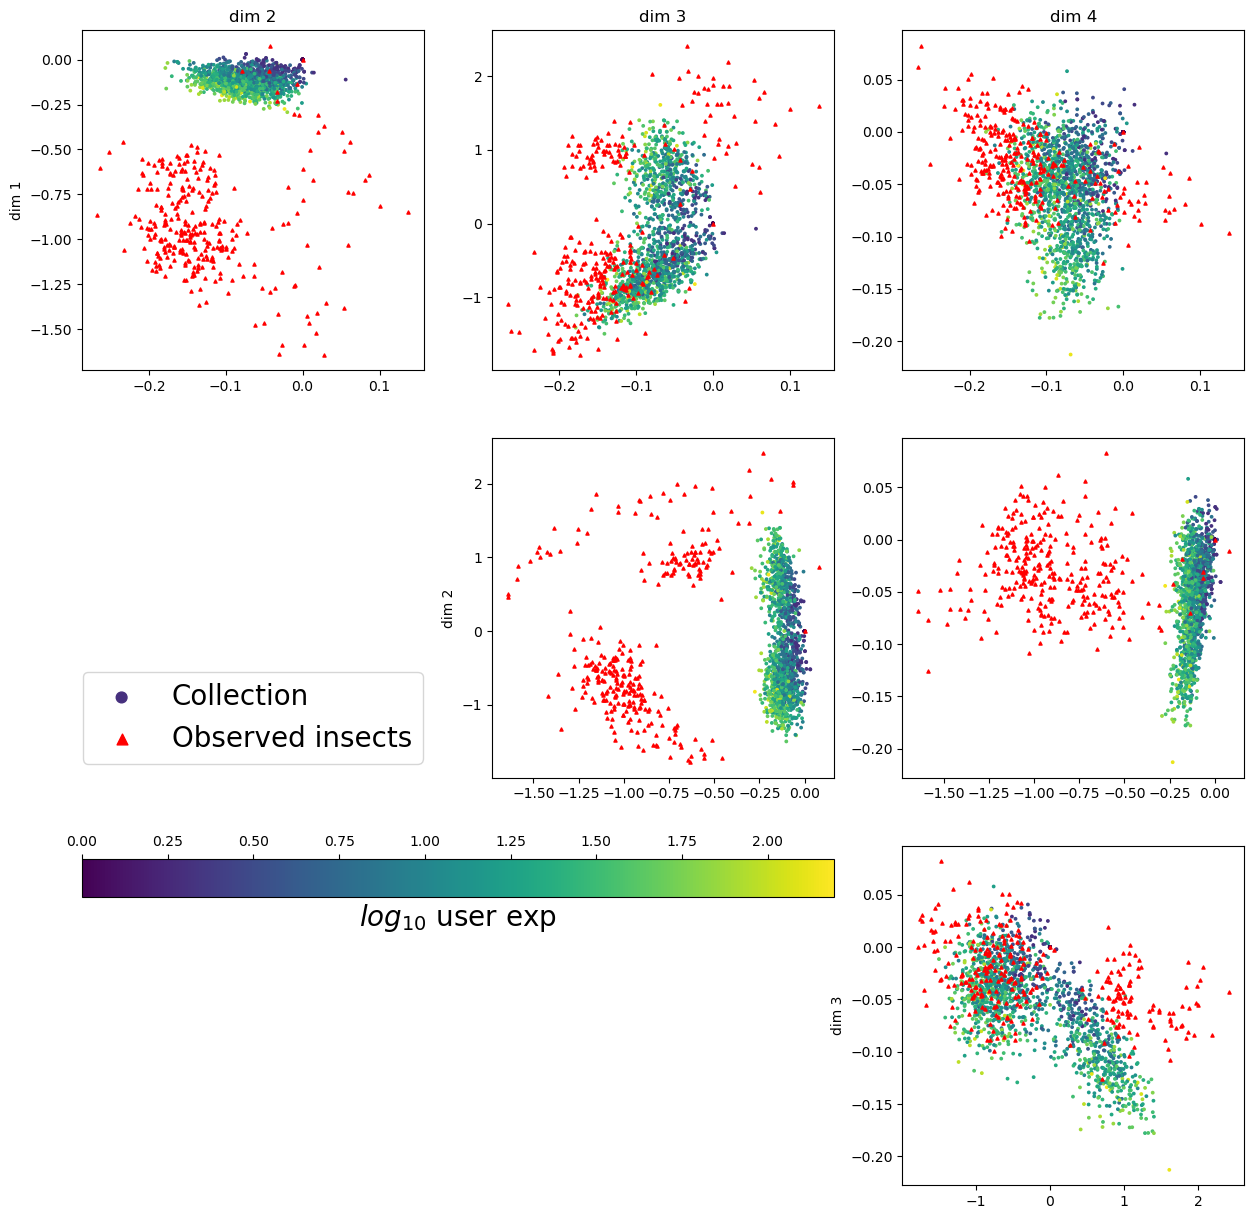

In [34]:
latent_space1 = model.mean1.detach().numpy()
latent_space2 = model.mean2.detach().numpy()

plot_latent_space(latent_space1,latent_space2,np.log10(S0[:,0].numpy()))
#plot_latent_space(latent_space1,latent_space2,S0[:,0].numpy())

/tmp/ipykernel_1106636/178291780.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


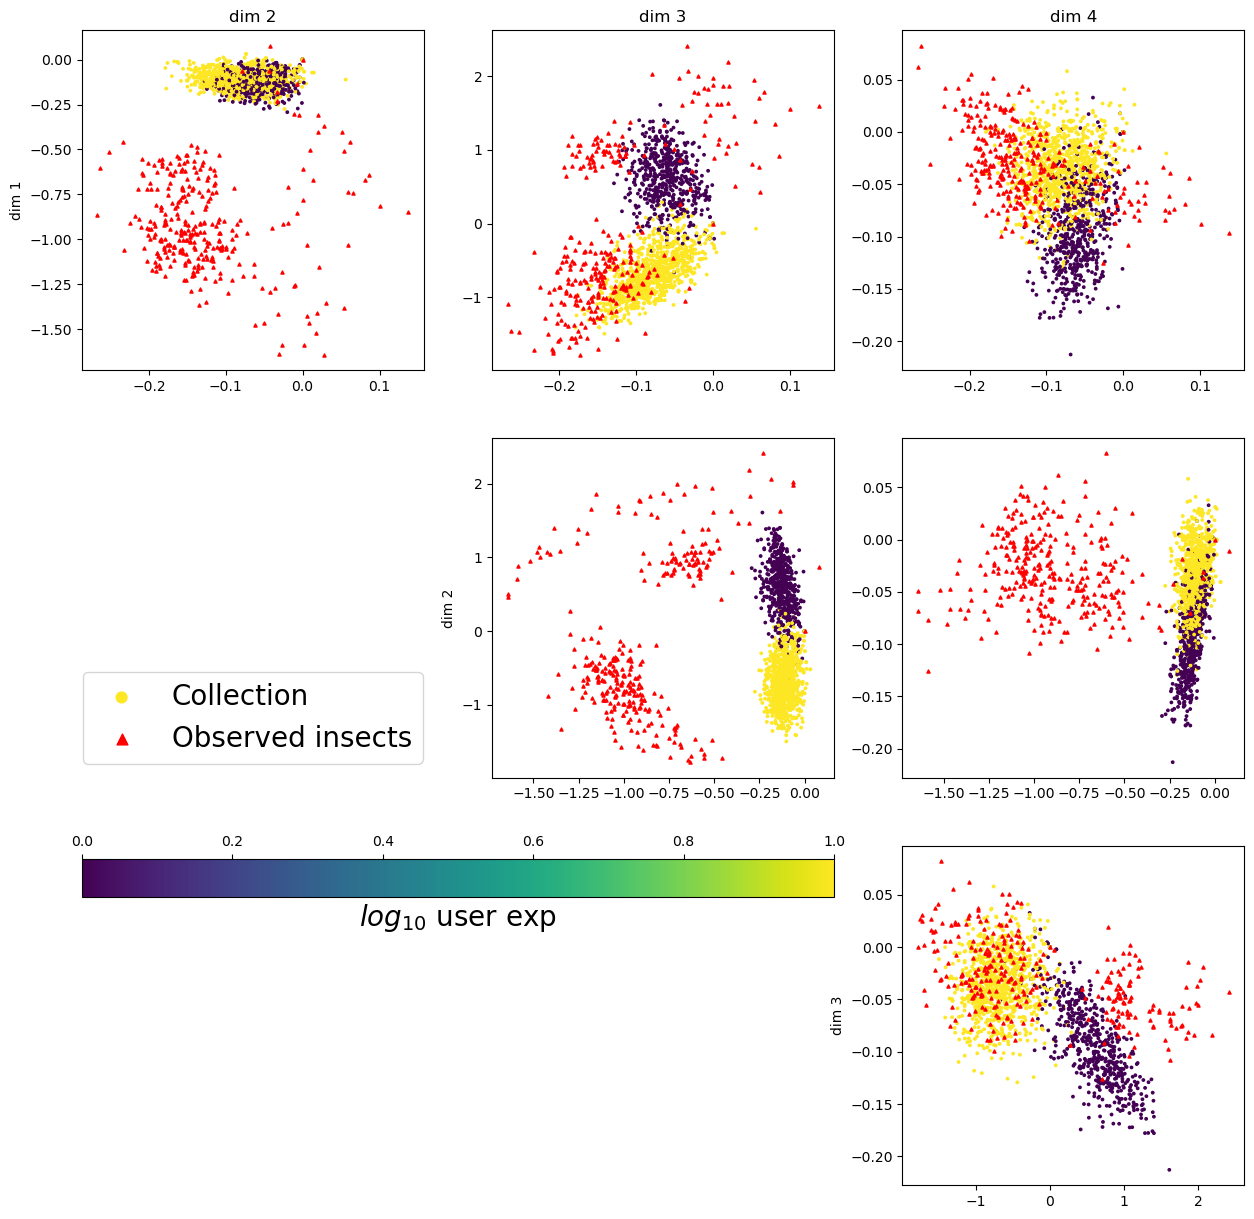

In [35]:
plot_latent_space(latent_space1,latent_space2,W1[species_index0])

In [111]:
torch.manual_seed(3)
model2 = VBGAE2(adj_norm,species_index)
init_parameters(model2)

optimizer = Adam(model2.parameters(), lr=args.learning_rate)

# train model2
roclist = []
loss_list= []


torch.manual_seed(2)
pbar = tqdm(range(int(args.num_epoch)),desc = "Training Epochs")
for epoch in pbar:
    t = time.time()

    A_pred,A_pred2,Z1,Z2,Z3 = model2(features1,features2)
    optimizer.zero_grad()
    loss  = norm2*F.binary_cross_entropy(A_pred2.view(-1), torch.Tensor(bipartite).view(-1),weight = weight_tensor2)
    loss += norm*F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1), weight = weight_tensor)
    kl_divergence = 0.5/ A_pred.size(0) *( (1 + 2*model2.logstd1 - model2.mean1**2 - torch.exp(model2.logstd1)**2).sum(1).mean()+
                                          (1 + 2*model2.logstd2 - model2.mean2**2 - torch.exp(model2.logstd2)**2).sum(1).mean())
    loss -= kl_divergence
    #independance =torch.log(RFF_HSIC(model2.mean1,S))
    independance = 0.25*n*RFF_HSIC(model2.mean1,S)
    loss += independance

    loss.backward()
    optimizer.step()
    

    val_roc, val_ap = get_scores(val_edges, val_edges_false, A_pred)
    val_roc2, val_ap2 = get_scores(val_edges2, val_edges_false2, A_pred2)
    
    roclist.append(val_roc2)
    loss_list.append(loss.item())

    pbar.set_postfix({"train_loss=": "{:.5f}".format(loss.item()),
                      'val_roc=': val_roc,
                      "val_roc2=": "{:.5f}".format(val_roc2) ,
                     "HSIC=": "{:.5f}".format(independance)})


Training Epochs: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s, train_loss==1.35134, val_roc==0.615, val_roc2==0.54936, HSIC==0.00251]


In [112]:
A_pred,A_pred2,Z1,Z2,Z3 = model2(features1,features2)

test_roc, test_ap = get_scores(test_edges, test_edges_false, A_pred)
print("1) End of training!", "test_roc=", "{:.5f}".format(test_roc),
      "test_ap=", "{:.5f}".format(test_ap))

test_roc2, test_ap2 = get_scores(test_edges2, test_edges_false2, A_pred2)
print("2) End of training!", "test_roc=", "{:.5f}".format(test_roc2),
      "test_ap=", "{:.5f}".format(test_ap2))


SP = (species01/species01.sum(0)).T.to_numpy()
A_pred3 = (SP@A_pred.detach().numpy())
test_roc3, test_ap3= get_scores(test_edges2, test_edges_false2,torch.Tensor(A_pred3))
print("3) End of training!", "test_roc=", "{:.5f}".format(test_roc3),
      "test_ap=", "{:.5f}".format(test_ap3))

1) End of training! test_roc= 0.60536 test_ap= 0.59202
2) End of training! test_roc= 0.48828 test_ap= 0.55532
3) End of training! test_roc= 0.48255 test_ap= 0.55318


In [113]:
print(scipy.stats.spearmanr(score0.reshape(-1,1),A_pred3.reshape(-1,1)))

NameError: name 'score0' is not defined

In [114]:
proba = (P[W1].T[W2]).T.reshape(-1,1)
print(scipy.stats.spearmanr(proba,A_pred3.reshape(-1,1)))

SignificanceResult(statistic=0.29391664818291624, pvalue=0.0)


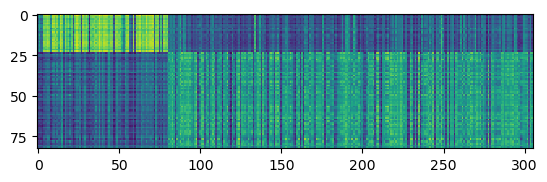

In [130]:
plt.imshow((A_pred3)[np.argsort(W1),:][:,np.argsort(W2)],interpolation="none")

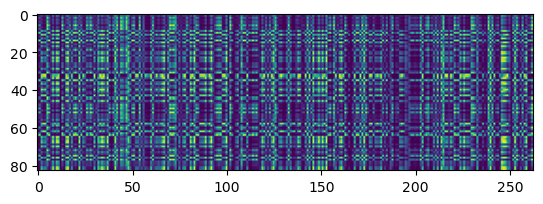

In [378]:
plt.imshow(A_pred3)

In [69]:
A_pred3[W1==0,:][:,W2==0].mean()

0.5937255676374689

In [70]:
A_pred3[W1==1,:][:,W2==1].mean()

0.5369020742885394

In [71]:
A_pred3[W1==1,:][:,W2==1].mean()/A_pred3[W1==0,:][:,W2==0].mean()

0.904293336103009

In [72]:
A_pred3[W1==0,:][:,W2==1].mean()

0.2679768801685276

In [73]:
A_pred3[W1==1,:][:,W2==0].mean()

0.3204914694189614

In [74]:
A_pred3[W1==0,:][:,W2==1].mean()/A_pred3[W1==1,:][:,W2==0].mean()

0.8361435661746608

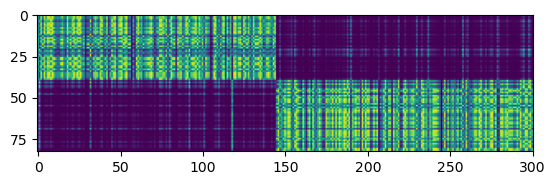

In [218]:
plt.imshow(A_pred3[:,np.argsort(z2[:,0]<0)][np.argsort(z1[:,0]<0),:])

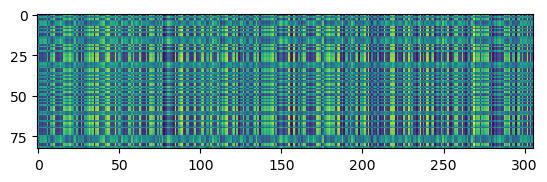

In [649]:
plt.imshow(A_pred3[:,np.argsort(W4)],interpolation="none")

In [575]:
A_pred3[:,W4==1].mean()-A_pred3[:,W4==0].mean()

-0.01063479538505463

In [219]:
np.round(np.corrcoef(model2.mean1.detach().numpy().T,S.T),3)


array([[ 1.   , -0.629,  0.773,  0.941, -0.004],
       [-0.629,  1.   , -0.966, -0.83 , -0.   ],
       [ 0.773, -0.966,  1.   ,  0.918,  0.001],
       [ 0.941, -0.83 ,  0.918,  1.   , -0.002],
       [-0.004, -0.   ,  0.001, -0.002,  1.   ]])

0.999406341845085

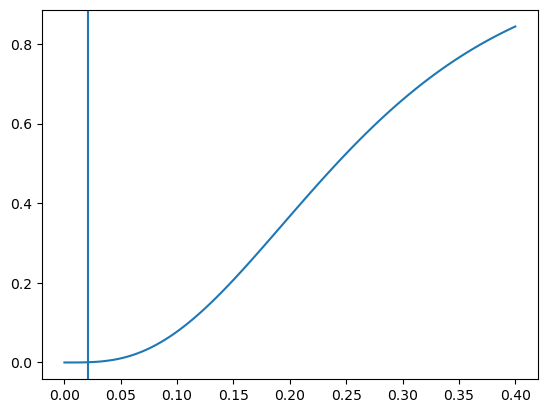

In [220]:
stat1 = HSIC_stat(model2.mean1,S)
x = np.linspace(0, 0.4, 100)
y = stats.gamma.cdf(x,stat1[3].item(),scale=stat1[4].item())
plt.plot(x,y)
plt.axvline(x = stat1[0].item()*n)
stats.gamma.sf(stat1[0].item()*n, stat1[3].item(), scale=stat1[4].item())

/tmp/ipykernel_4293/2014364723.py:3: RuntimeWarning: invalid value encountered in log10
  plot_latent_space(latent_space1,latent_space2,np.log10(S0[:,0].numpy()))
/tmp/ipykernel_4293/178291780.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


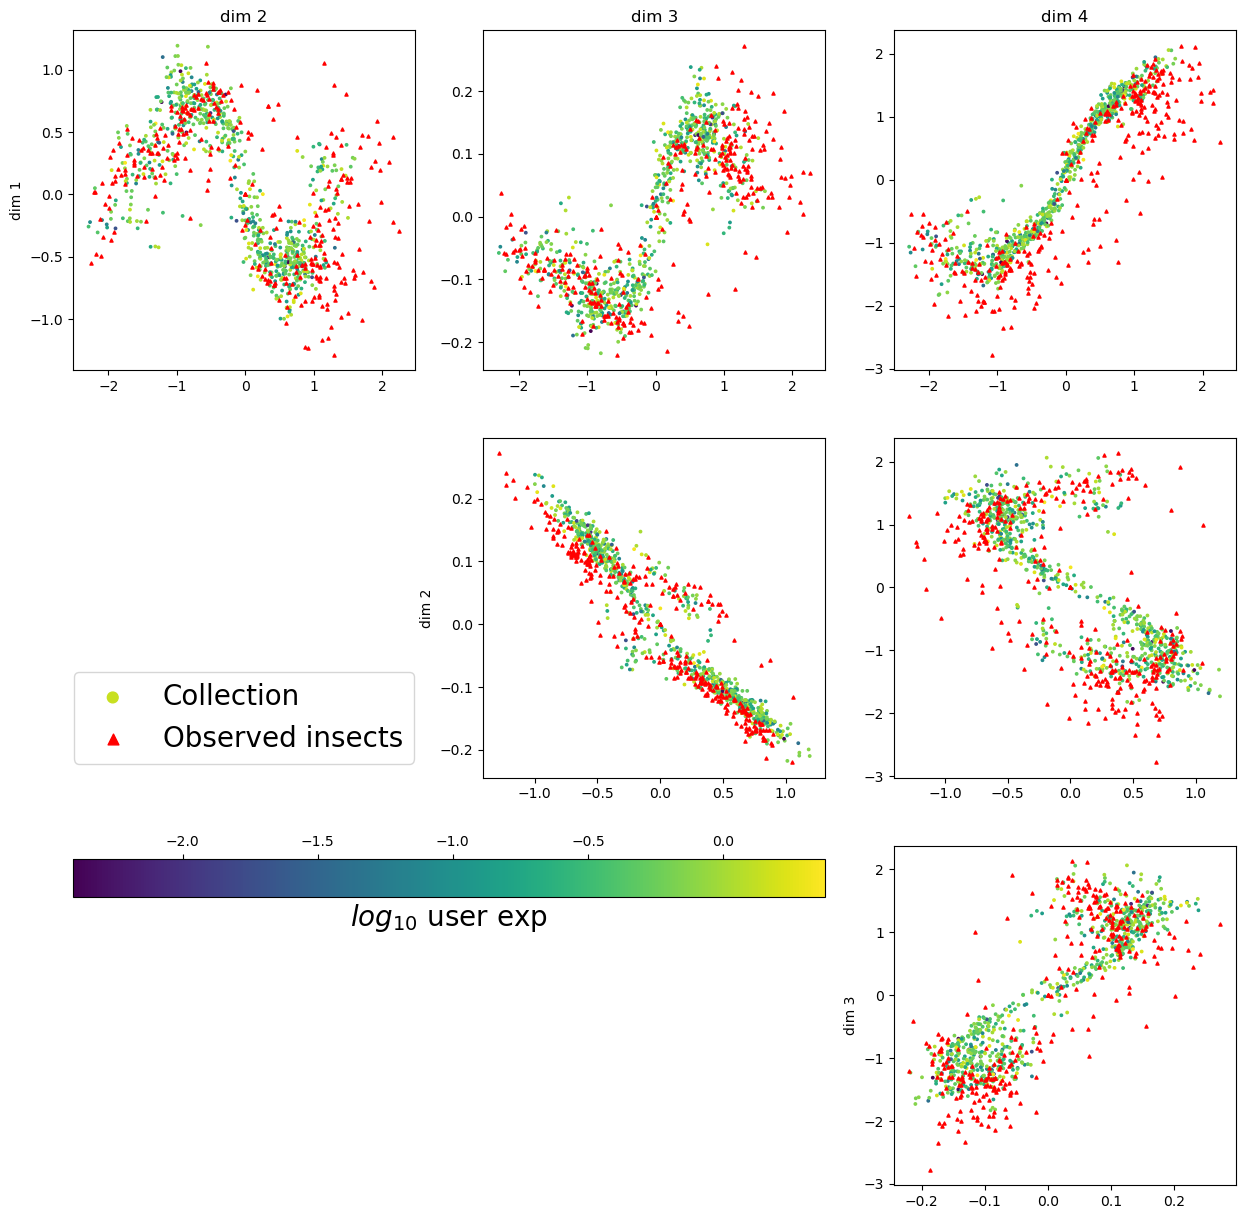

In [221]:
latent_space1 = model2.mean1.detach().numpy()
latent_space2 = model2.mean2.detach().numpy()
plot_latent_space(latent_space1,latent_space2,np.log10(S0[:,0].numpy()))

/tmp/ipykernel_1101835/178291780.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


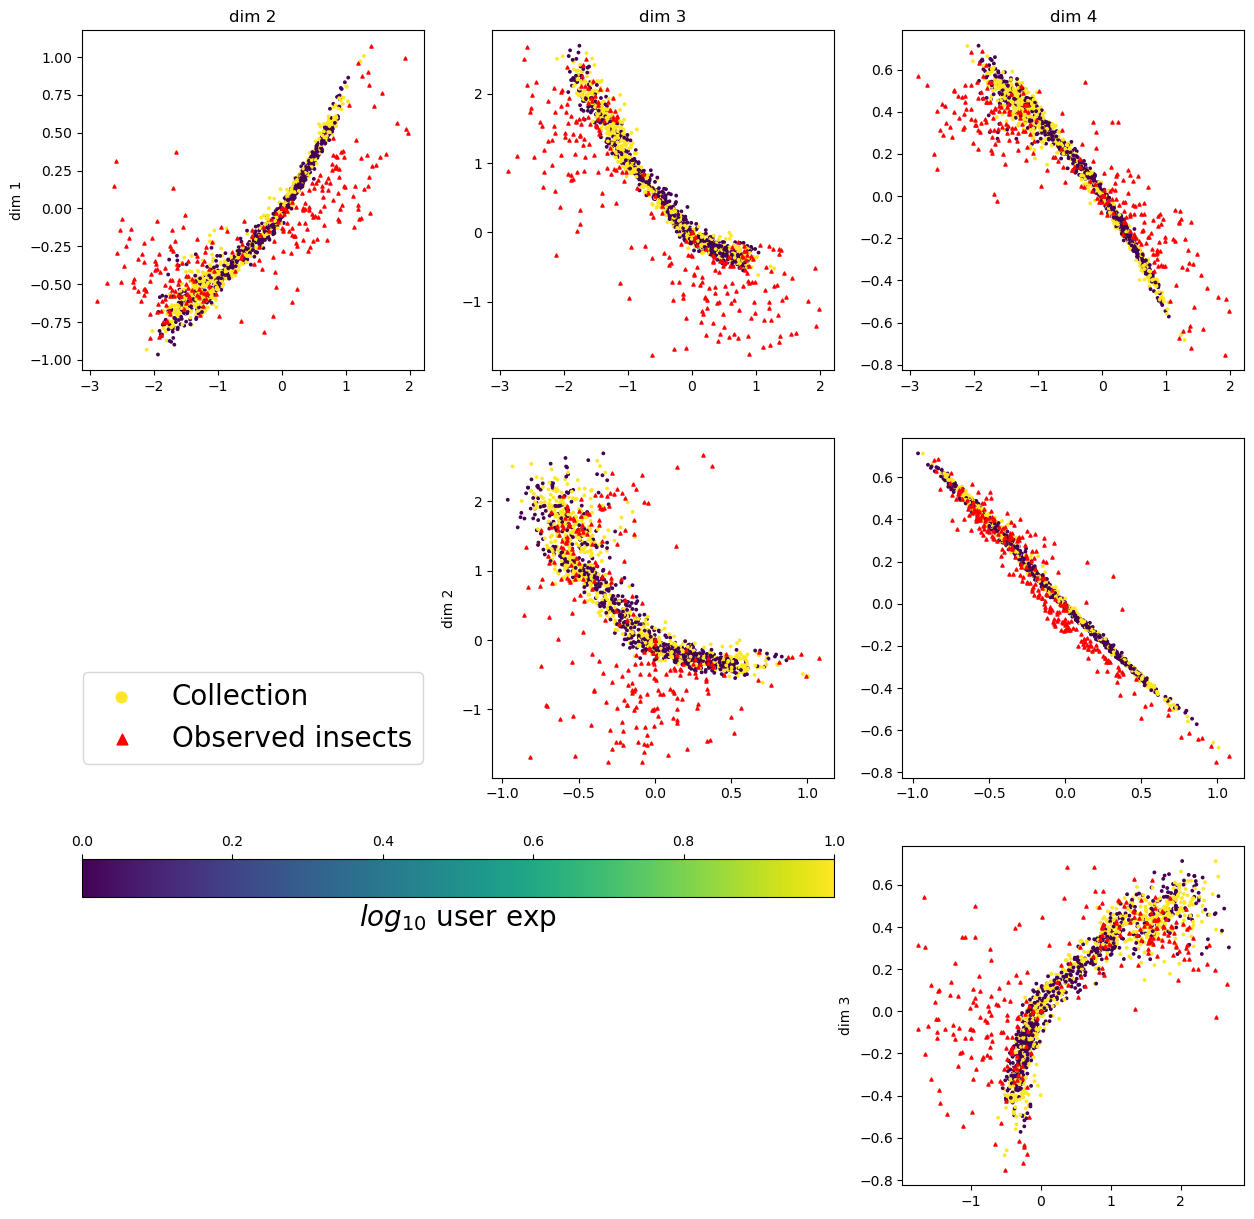

In [560]:
plot_latent_space(latent_space1,latent_space2,W1[species_index0])

In [26]:
def mask_test_edges3(adj_label,species, ground_truth, val_edges, val_edges_false, test_edges, test_edges_false):
        
    bipartite = 1*(species.T.dot(adj_label.to_dense().numpy())>0) #bipartite observé (train)
    forbidden = (bipartite==1) #on  ne test pas sur les arrêtes observées
    val_edges2 = np.zeros(adj_label.shape) 
    val_edges2[val_edges]=1
    val_edges2=species.T.dot(val_edges2)
    val_edges2= (val_edges2>0)& np.logical_not(forbidden) #contient les arrêtes de validation
    forbidden = forbidden + val_edges2 #update forbidden
    
    val_edges_false2=np.zeros(adj_label.shape) 
    val_edges_false2[val_edges_false]=1
    val_edges_false2=species.T.dot(val_edges_false2)
    val_edges_false2=(val_edges_false2>0) & np.logical_not(forbidden)#contient les non arrêtes de validation
    forbidden = forbidden + val_edges_false2
    
    
    #test_edges2 = np.zeros(adj_label.shape)
    #test_edges2[test_edges]=1
    test_edges2 = ground_truth
    test_edges2 = (test_edges2>0)& np.logical_not(forbidden)#contient les arrêtes de test
    forbidden = forbidden + test_edges2
    
    
    #test_edges_false2=np.zeros(adj_label.shape)
    #test_edges_false2[test_edges_false]=1
    
    #test_edges_false2=species.T.dot(test_edges_false2) #contient les non-arrêtes de test
    test_edges_false2 = 1-ground_truth
    test_edges_false2=(test_edges_false2>0)& np.logical_not(forbidden)
    
    n_sample = np.min([val_edges2.sum(),val_edges_false2.sum()])
    val_edges2 = np.where(val_edges2)
    val_edges_false2 = np.where(val_edges_false2)    
    i1=np.random.choice(range(val_edges2[0].shape[0]),n_sample,replace=False)
    i2= np.random.choice(range(val_edges_false2[0].shape[0]),n_sample,replace=False)
    val_edges2 = val_edges2[0][i1],val_edges2[1][i1]
    val_edges_false2 = val_edges_false2[0][i2],val_edges_false2[1][i2]
    
    n_sample = np.min([test_edges2.sum(),test_edges_false2.sum()])
    test_edges2 = np.where(test_edges2)
    test_edges_false2 = np.where(test_edges_false2)    
    i1=np.random.choice(range(test_edges2[0].shape[0]),n_sample,replace=False)
    i2= np.random.choice(range(test_edges_false2[0].shape[0]),n_sample,replace=False)
    test_edges2 = test_edges2[0][i1],test_edges2[1][i1]
    test_edges_false2 = test_edges_false2[0][i2],test_edges_false2[1][i2]
    
    return bipartite,val_edges2,val_edges_false2,test_edges2,test_edges_false2


In [706]:
proba = (P[W1].T[W2]).T

In [41]:
import scipy

In [709]:
scipy.stats.spearmanr(proba[bipartite_obs==0].reshape(-1,1),
                      A_pred3[bipartite_obs==0].reshape(-1,1))

SignificanceResult(statistic=0.7699061342960623, pvalue=0.0)

array([0.1, 0.7, 0.1, ..., 0.1, 0.1, 0.1])